In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from tqdm import tqdm
import json
import torch
from natsort import natsorted
# import SimpleITK as sitk

import warnings
warnings.filterwarnings('ignore')

In [3]:
from src.scripts.models.U2Net import U2Net 
from torch.utils.data import TensorDataset, DataLoader, Dataset
# from torchvision import transforms
import torchvision.transforms.v2 as transforms

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# # Exactly the same interface as V1:
# trans = transforms.Compose([
#     transforms.ColorJitter(contrast=0.5),
#     transforms.RandomRotation(30),
#     transforms.CenterCrop(480),
# ])
# imgs, bboxes, labels = trans(imgs, bboxes, labels)

In [5]:
# Write transform for image
data_transform = transforms.Compose([
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    # transforms.ColorJitter(contrast=0.1), 
    # Resize the images to 64x64
    transforms.Resize(size=(512, 512)),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # transforms.RandomRotation(50),
])

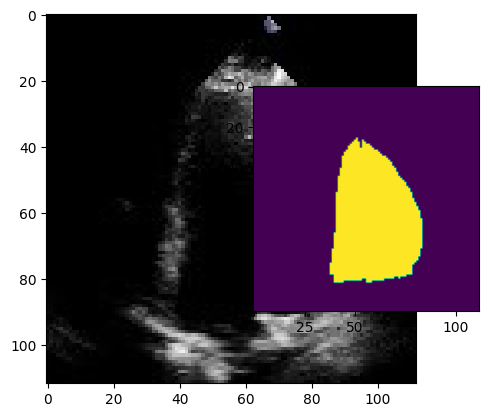

In [6]:
test_img = cv2.imread('data/train/echoLV/testing/images/0X6FA8D7C2278B5073_3.jpg')
test_msk = cv2.imread('data/train/echoLV/testing/masks/0X6FA8D7C2278B5073_3.png', 0)
plt.imshow(test_img)
plt.subplot(122)
plt.imshow(test_msk)

torch.Size([3, 512, 512]) torch.Size([1, 112, 112])


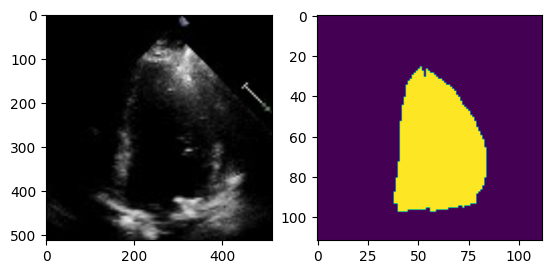

In [7]:
new_img, new_msk = data_transform(test_img, test_msk)
print(new_img.shape, new_msk.shape)
plt.subplot(121)
plt.imshow(np.transpose(new_img.cpu().detach().numpy(), (1, 2, 0)))
plt.subplot(122)
plt.imshow(np.transpose(new_msk.cpu().detach().numpy(), (1, 2, 0)))

In [20]:
class MyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """ """
        assert len(image_paths) == len(mask_paths)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        msk_path = self.mask_paths[index]
        image = self.load_image(img_path, as_mask=False)
        mask = self.load_image(msk_path, as_mask=True)
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, path, as_mask=False):
        if as_mask:
            img = cv2.imread(path, 0)
            img = np.where(img > 0, 1, 0)
        else:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img

In [13]:
def get_paths(main_path):
    img_paths = [os.path.join(main_path, "images", img_name) for img_name in os.listdir(os.path.join(main_path, 'images'))]
    msk_paths = [os.path.join(main_path, "masks", img_name) for img_name in os.listdir(os.path.join(main_path, 'masks'))]
    img_paths = natsorted(img_paths)
    msk_paths = natsorted(msk_paths)

    return img_paths, msk_paths

In [14]:
train_path = 'data/train/echoLV/training'
test_path = 'data/train/echoLV/testing'

train_img_paths, train_msk_paths = get_paths(train_path)
test_img_paths, test_msk_paths = get_paths(test_path)

train_img_paths[:5], train_msk_paths[:5]

(['data/train/echoLV/training/images/0X1A0A263B22CCD966_72.jpg',
  'data/train/echoLV/training/images/0X1A0A263B22CCD966_83.jpg',
  'data/train/echoLV/training/images/0X1A2A76BDB5B98BED_63.jpg',
  'data/train/echoLV/training/images/0X1A2A76BDB5B98BED_78.jpg',
  'data/train/echoLV/training/images/0X1A2C60147AF9FDAE_46.jpg'],
 ['data/train/echoLV/training/masks/0X1A0A263B22CCD966_72.png',
  'data/train/echoLV/training/masks/0X1A0A263B22CCD966_83.png',
  'data/train/echoLV/training/masks/0X1A2A76BDB5B98BED_63.png',
  'data/train/echoLV/training/masks/0X1A2A76BDB5B98BED_78.png',
  'data/train/echoLV/training/masks/0X1A2C60147AF9FDAE_46.png'])

In [15]:
train_img_paths[-5:], train_msk_paths[-5:]

(['data/train/echoLV/training/images/nii_patient0448_4CH_ES.jpg',
  'data/train/echoLV/training/images/nii_patient0449_2CH_ED.jpg',
  'data/train/echoLV/training/images/nii_patient0449_2CH_ES.jpg',
  'data/train/echoLV/training/images/nii_patient0449_4CH_ED.jpg',
  'data/train/echoLV/training/images/nii_patient0449_4CH_ES.jpg'],
 ['data/train/echoLV/training/masks/nii_patient0448_4CH_ES_gt.png',
  'data/train/echoLV/training/masks/nii_patient0449_2CH_ED_gt.png',
  'data/train/echoLV/training/masks/nii_patient0449_2CH_ES_gt.png',
  'data/train/echoLV/training/masks/nii_patient0449_4CH_ED_gt.png',
  'data/train/echoLV/training/masks/nii_patient0449_4CH_ES_gt.png'])

In [16]:
test_img_paths[:5], test_msk_paths[:5]

(['data/train/echoLV/testing/images/0X6FA8D7C2278B5073_3.jpg',
  'data/train/echoLV/testing/images/0X6FA8D7C2278B5073_31.jpg',
  'data/train/echoLV/testing/images/0X6FA1794B8CBE3C04_75.jpg',
  'data/train/echoLV/testing/images/0X6FA1794B8CBE3C04_90.jpg',
  'data/train/echoLV/testing/images/0X6FAA89F3C9D58522_39.jpg'],
 ['data/train/echoLV/testing/masks/0X6FA8D7C2278B5073_3.png',
  'data/train/echoLV/testing/masks/0X6FA8D7C2278B5073_31.png',
  'data/train/echoLV/testing/masks/0X6FA1794B8CBE3C04_75.png',
  'data/train/echoLV/testing/masks/0X6FA1794B8CBE3C04_90.png',
  'data/train/echoLV/testing/masks/0X6FAA89F3C9D58522_39.png'])

In [22]:
# 
train_dataset = MyDataset(train_img_paths, train_msk_paths, transform=data_transform)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = MyDataset(test_img_paths, test_msk_paths, transform=data_transform)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)


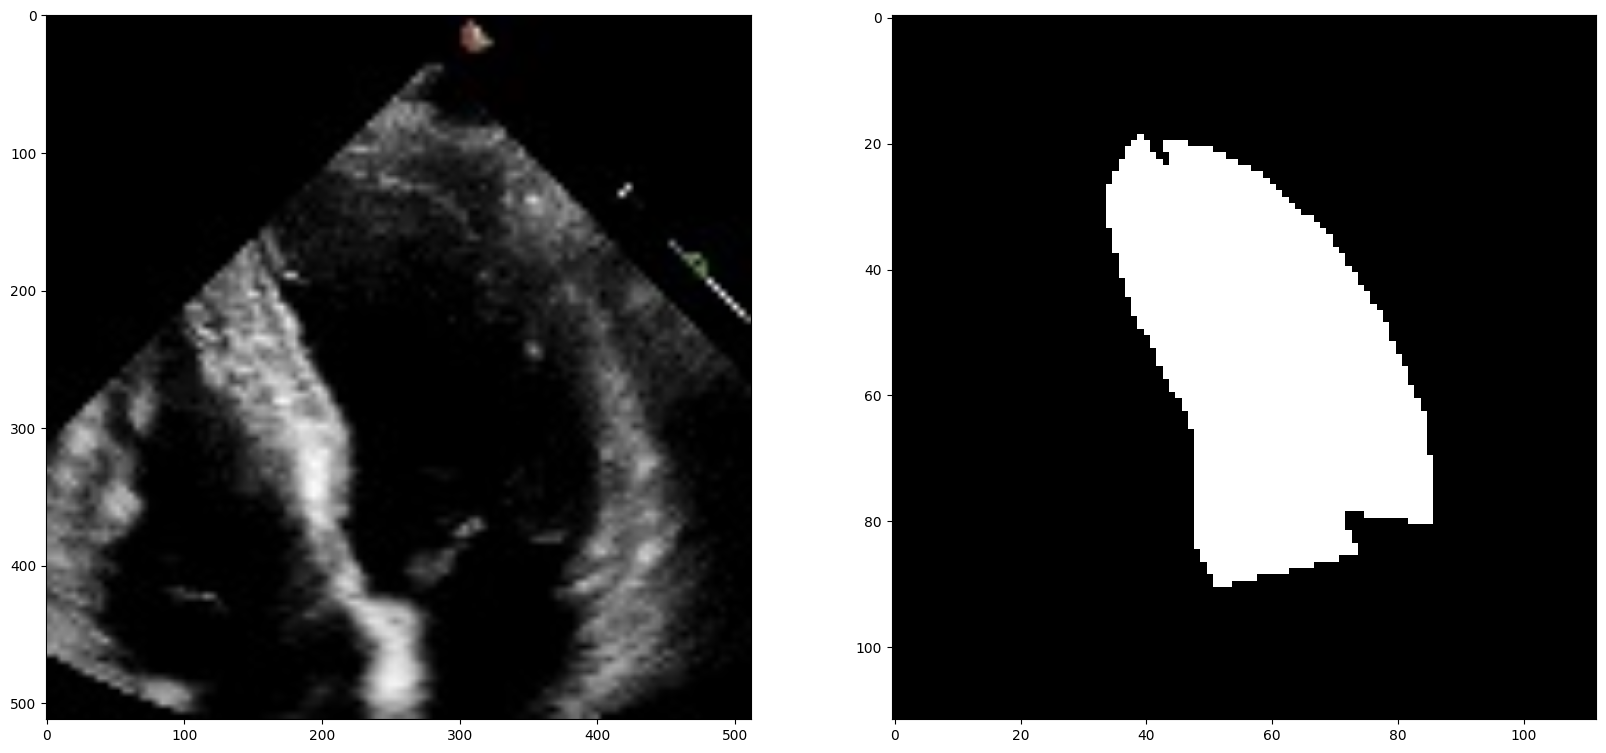

In [26]:
from src.scripts.DataLoaders import ImgForPlot


im, m = train_dataset[10]
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');